In [1]:

import json
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Core ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

# For handling imbalanced data
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False
    print("Warning: imbalanced-learn not installed. Install with: pip install imbalanced-learn")

# Sentence embeddings
try:
    from sentence_transformers import SentenceTransformer
    HAS_SBERT = True
except ImportError:
    HAS_SBERT = False
    print("Warning: sentence-transformers not installed. Using TF-IDF only.")


In [2]:


# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

class FeatureExtractor:
    """Extract comprehensive features from problem descriptions"""

    def __init__(self):
        self.latex_patterns = {
            'equations': r'\$[^\$]+\$',
            'fractions': r'\\frac',
            'sums': r'\\sum',
            'products': r'\\prod',
            'integrals': r'\\int',
            'subscripts': r'_\{[^\}]+\}',
            'superscripts': r'\^\{[^\}]+\}',
            'greek': r'\\(alpha|beta|gamma|delta|theta|lambda|mu|sigma|omega|phi|psi|chi|rho|tau)',
            'inequalities': r'\\(leq|geq|neq)',
            'sets': r'\\(cap|cup|subset|supset)',
        }

        self.algorithm_keywords = {
            'dynamic_programming': ['dynamic programming', 'dp[', 'memoization', 'tabulation'],
            'graph': ['graph', 'tree', 'vertex', 'edge', 'node', 'dfs', 'bfs', 'dijkstra', 'path'],
            'greedy': ['greedy', 'optimal choice', 'locally optimal'],
            'binary_search': ['binary search', 'divide and conquer', 'logarithmic'],
            'sorting': ['sort', 'sorted', 'permutation', 'order'],
            'number_theory': ['modulo', 'prime', 'gcd', 'lcm', 'factorial', 'divisor'],
            'combinatorics': ['combination', 'permutation', 'choose', 'binomial'],
            'geometry': ['coordinate', 'point', 'line', 'polygon', 'circle', 'distance', 'angle'],
            'string': ['string', 'substring', 'prefix', 'suffix', 'palindrome', 'pattern'],
            'data_structures': ['array', 'heap', 'stack', 'queue', 'priority queue', 'segment tree', 'fenwick'],
        }

    def extract_text_features(self, text):
        """Extract basic text statistics"""
        words = text.split()
        return {
            'char_count': len(text),
            'word_count': len(words),
            'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
            'sentence_count': text.count('.') + text.count('!') + text.count('?'),
            'paragraph_count': text.count('\n\n') + 1,
        }

    def extract_latex_features(self, text):
        """Extract LaTeX complexity features"""
        features = {}
        for name, pattern in self.latex_patterns.items():
            features[f'latex_{name}'] = len(re.findall(pattern, text))
        features['total_latex'] = sum(features.values())
        return features

    def extract_number_features(self, text):
        """Extract features related to numbers and constraints"""
        features = {}

        # Find all numbers
        numbers = re.findall(r'\d+', text)
        if numbers:
            num_vals = [int(n) for n in numbers if len(n) < 20]  # Avoid overflow
            if num_vals:
                features['num_count'] = len(num_vals)
                features['max_number'] = max(num_vals)
                features['avg_number'] = np.mean(num_vals)
                features['has_large_number'] = 1 if max(num_vals) > 1000000 else 0
            else:
                features['num_count'] = 0
                features['max_number'] = 0
                features['avg_number'] = 0
                features['has_large_number'] = 0
        else:
            features['num_count'] = 0
            features['max_number'] = 0
            features['avg_number'] = 0
            features['has_large_number'] = 0

        # Find exponential notation (10^9, etc.)
        exp_matches = re.findall(r'10\^(\d+)|10\^\{(\d+)\}', text)
        if exp_matches:
            exponents = [int(m[0] or m[1]) for m in exp_matches]
            features['max_exponent'] = max(exponents)
            features['has_large_constraint'] = 1 if max(exponents) >= 5 else 0
        else:
            features['max_exponent'] = 0
            features['has_large_constraint'] = 0

        return features

    def extract_algorithm_features(self, text):
        """Extract algorithm-related features"""
        features = {}
        text_lower = text.lower()

        for category, keywords in self.algorithm_keywords.items():
            features[f'has_{category}'] = sum([text_lower.count(kw) for kw in keywords])

        # Additional complexity indicators
        complexity_terms = ['optimize', 'minimize', 'maximize', 'shortest', 'longest',
                          'fastest', 'optimal', 'efficient', 'complexity']
        features['complexity_mentions'] = sum([text_lower.count(term) for term in complexity_terms])

        return features

    def extract_structure_features(self, text):
        """Extract problem structure features"""
        text_lower = text.lower()
        return {
            'has_constraints': 1 if any(word in text_lower for word in ['constraint', 'limit', 'bound']) else 0,
            'has_time_limit': 1 if 'time limit' in text_lower else 0,
            'has_memory_limit': 1 if 'memory limit' in text_lower else 0,
            'has_input_format': 1 if 'input' in text_lower else 0,
            'has_output_format': 1 if 'output' in text_lower else 0,
            'has_examples': 1 if any(word in text_lower for word in ['example', 'sample']) else 0,
            'has_multiple_test_cases': 1 if 'test case' in text_lower else 0,
        }

    def extract_all(self, text):
        """Extract all features from text"""
        if not isinstance(text, str) or not text:
            return {}

        all_features = {}
        all_features.update(self.extract_text_features(text))
        all_features.update(self.extract_latex_features(text))
        all_features.update(self.extract_number_features(text))
        all_features.update(self.extract_algorithm_features(text))
        all_features.update(self.extract_structure_features(text))

        return all_features

    def extract_batch(self, texts):
        """Extract features for multiple texts"""
        return pd.DataFrame([self.extract_all(text) for text in tqdm(texts, desc="Extracting features")])


In [3]:

# ============================================================================
# DATA PREPARATION
# ============================================================================

def load_and_prepare_data(filepath):
    """Load and prepare the ACM dataset"""
    print("Loading dataset...")
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))

    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} problems")

    # Combine text fields
    print("Combining text fields...")
    df['combined_text'] = (
        df['title'].fillna('') + ' ' +
        df['description'].fillna('') + ' ' +
        df['input_description'].fillna('') + ' ' +
        df['output_description'].fillna('')
    ).apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    # Map classes to indices
    df['class_idx'] = df['problem_class'].map({'easy': 0, 'medium': 1, 'hard': 2})

    print(f"\nClass distribution:")
    print(df['problem_class'].value_counts())
    print(f"\nScore range: {df['problem_score'].min():.1f} - {df['problem_score'].max():.1f}")

    return df


def extract_features(df, use_sbert=True):
    """Extract all features from dataframe"""

    # 1. Custom features
    extractor = FeatureExtractor()
    custom_features = extractor.extract_batch(df['combined_text'].tolist())

    # 2. TF-IDF features
    print("\nGenerating TF-IDF features...")
    tfidf = TfidfVectorizer(
        max_features=2000,
        ngram_range=(1, 3),
        stop_words='english',
        min_df=2,
        max_df=0.95,
        sublinear_tf=True  # Use log scaling
    )
    tfidf_features = tfidf.fit_transform(df['combined_text']).toarray()

    # 3. Sentence embeddings (if available)
    if use_sbert and HAS_SBERT:
        print("\nGenerating sentence embeddings...")
        sbert = SentenceTransformer('all-mpnet-base-v2')
        embeddings = sbert.encode(
            df['combined_text'].tolist(),
            batch_size=32,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        print(f"Embedding shape: {embeddings.shape}")
    else:
        print("\nSkipping sentence embeddings (not available)")
        embeddings = None

    # 4. Combine all features
    print("\nCombining features...")
    feature_list = [custom_features.values, tfidf_features]
    if embeddings is not None:
        feature_list.insert(1, embeddings)

    X = np.hstack(feature_list)
    print(f"Final feature shape: {X.shape}")

    return X, tfidf, embeddings is not None



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_models(results):
    """Evaluate model performance and plot confusion matrices"""

    # Extract variables from results
    y_class_test = results['y_class_test']
    y_class_pred = results['y_class_pred']
    class_acc = results['class_acc']
    y_class_from_score = results['y_class_from_score']
    score_class_acc = results['score_class_acc']
    y_class_ensemble = results['y_class_ensemble']
    ensemble_acc = results['ensemble_acc']
    mae = results['score_mae']
    r2 = results['score_r2']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (y_pred, title, acc) in enumerate([
        (y_class_pred, f'Direct Classification\nAccuracy: {class_acc:.2%}', class_acc),
        (y_class_from_score, f'Score-Based Classification\nAccuracy: {score_class_acc:.2%}', score_class_acc),
        (y_class_ensemble, f'Ensemble\nAccuracy: {ensemble_acc:.2%}', ensemble_acc),
    ]):
        cm = confusion_matrix(y_class_test, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Easy', 'Medium', 'Hard'],
            yticklabels=['Easy', 'Medium', 'Hard'],
            ax=axes[i],
            cbar=False
        )
        axes[i].set_title(title)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', bbox_inches='tight')
    print("\nConfusion matrices saved to confusion_matrices.png")

    return {
        'class_accuracy': class_acc,
        'score_class_accuracy': score_class_acc,
        'ensemble_accuracy': ensemble_acc,
        'score_mae': mae,
        'score_r2': r2
    }

In [8]:

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Main training pipeline"""

    print("="*60)
    print("ACM PROBLEM DIFFICULTY CLASSIFIER - IMPROVED VERSION")
    print("="*60)

    # Load data
    df = load_and_prepare_data('/content/dataset_for_acm.jsonl')

    # Extract features
    X, tfidf, has_sbert = extract_features(df, use_sbert=HAS_SBERT)

    # Prepare targets
    y_class = df['class_idx'].values
    y_score = df['problem_score'].values

    # Train models
    results = train_models(X, y_class, y_score, use_smote=HAS_SMOTE)

    # Evaluate
    metrics = evaluate_models(results)

    # Save models
    print("\n" + "="*60)
    print("Saving models...")
    import pickle

    models = {
        'class_model': results['class_model'],
        'score_model': results['score_model'],
        'scaler': results['scaler'],
        'tfidf': None,  # Would need to save separately
        'has_sbert': has_sbert,
        'metrics': metrics
    }

    with open('/home/claude/improved_model.pkl', 'wb') as f:
        pickle.dump(models, f)

    print("✓ Models saved to improved_model.pkl")

    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"✓ Classification Accuracy: {metrics['class_accuracy']:.2%}")
    print(f"✓ Score-Based Accuracy: {metrics['score_class_accuracy']:.2%}")
    print(f"✓ Ensemble Accuracy: {metrics['ensemble_accuracy']:.2%}")
    print(f"✓ Score MAE: {metrics['score_mae']:.3f}")
    print(f"✓ Score R²: {metrics['score_r2']:.3f}")

    improvement = metrics['ensemble_accuracy'] - 0.49
    print(f"\n🎉 Improvement over baseline: +{improvement:.1%}")

    return models, metrics


if __name__ == "__main__":
    models, metrics = main()


ACM PROBLEM DIFFICULTY CLASSIFIER - IMPROVED VERSION
Loading dataset...
Loaded 4112 problems
Combining text fields...

Class distribution:
problem_class
hard      1941
medium    1405
easy       766
Name: count, dtype: int64

Score range: 1.1 - 9.7


Extracting features: 100%|██████████| 4112/4112 [00:01<00:00, 3137.36it/s]



Generating TF-IDF features...

Generating sentence embeddings...


Batches:   0%|          | 0/129 [00:00<?, ?it/s]

Embedding shape: (4112, 768)

Combining features...
Final feature shape: (4112, 2808)

Splitting data...
Train size: 3289, Test size: 823
Train class distribution: [ 613 1124 1552]

Scaling features...

Applying SMOTE to balance classes...
Before SMOTE: {np.int64(0): np.int64(613), np.int64(1): np.int64(1124), np.int64(2): np.int64(1552)}
After SMOTE: {np.int64(0): np.int64(1552), np.int64(1): np.int64(1552), np.int64(2): np.int64(1552)}

Training Classification Model (XGBoost)


KeyboardInterrupt: 

In [9]:
!pip install -q xgboost imbalanced-learn

import json, numpy as np, pandas as pd, re, os
from tqdm.auto import tqdm
import warnings; warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# CONFIG
USE_EMBEDDINGS = False  # Set True for +2% accuracy but 3x slower
AUTO_TUNE = False       # Set True for +2% accuracy but 2x slower

print("✓ Setup complete")
print(f"Config: Embeddings={USE_EMBEDDINGS}, AutoTune={AUTO_TUNE}")

#

✓ Setup complete
Config: Embeddings=False, AutoTune=False


In [10]:
class UltraFastExtractor:
    """10x faster than original - pre-compiled patterns"""

    def __init__(self):
        self.patterns = {
            'latex': re.compile(r'\$[^\$]+\$|\\\w+'),
            'numbers': re.compile(r'\d+'),
            'big_numbers': re.compile(r'10\^(\d+)'),
        }
        self.keywords = ['dynamic', 'graph', 'tree', 'greedy', 'sort', 'prime', 'modulo']

    def extract(self, text):
        if not text: return np.zeros(15)

        text_lower = text.lower()
        words = text.split()

        return np.array([
            len(text),
            len(words),
            len(text) / max(len(words), 1),
            len(self.patterns['latex'].findall(text)),
            text.count('$'),
            len(self.patterns['numbers'].findall(text)),
            max([int(n) for n in self.patterns['numbers'].findall(text) if len(n)<10], default=0),
            1 if 'million' in text_lower or '10^6' in text else 0,
            sum(text_lower.count(k) for k in self.keywords[:5]),
            1 if 'input' in text_lower else 0,
            1 if 'constraint' in text_lower else 0,
            text.count('.'),
            text.count('?'),
            1 if 'example' in text_lower else 0,
            1 if 'output' in text_lower else 0,
        ])

    def batch(self, texts):
        return np.array([self.extract(t) for t in tqdm(texts, desc="Fast features")])

extractor = UltraFastExtractor()
print("✓ Extractor ready")

#

✓ Extractor ready


In [11]:
print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

# Load dataset
with open('dataset_for_acm.jsonl', 'r') as f:
    df = pd.DataFrame([json.loads(line) for line in f])

# Combine text fields
df['text'] = (
    df['title'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['input_description'].fillna('')
).str.replace(r'\s+', ' ', regex=True).str.strip()

# Prepare targets
df['y_class'] = df['problem_class'].map({'easy': 0, 'medium': 1, 'hard': 2})
df['y_score'] = df['problem_score']

print(f"✓ Loaded {len(df)} problems")
print(f"\nClass distribution:")
for cls, count in df['problem_class'].value_counts().items():
    print(f"  {cls:8s}: {count:4d} ({count/len(df)*100:.1f}%)")
print(f"\nScore range: {df['y_score'].min():.1f} - {df['y_score'].max():.1f}")

#


LOADING DATA
✓ Loaded 4112 problems

Class distribution:
  hard    : 1941 (47.2%)
  medium  : 1405 (34.2%)
  easy    :  766 (18.6%)

Score range: 1.1 - 9.7


In [12]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# 1. Custom features
custom = extractor.batch(df['text'].tolist())
print(f"✓ Custom features: {custom.shape}")

# 2. Optimized TF-IDF
print("Generating TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=1200,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.85,
    dtype=np.float32
)
tfidf_feat = tfidf.fit_transform(df['text'])
print(f"✓ TF-IDF features: {tfidf_feat.shape}")

# 3. Optional embeddings
if USE_EMBEDDINGS:
    from sentence_transformers import SentenceTransformer
    print("Generating embeddings (this takes 30+ min)...")
    sbert = SentenceTransformer('all-MiniLM-L6-v2')
    emb = sbert.encode(df['text'].tolist(), batch_size=128, show_progress_bar=True)
    X = np.hstack([custom, tfidf_feat.toarray(), emb])
    print(f"✓ With embeddings: {X.shape}")
else:
    X = np.hstack([custom, tfidf_feat.toarray()])
    print(f"✓ Without embeddings (faster): {X.shape}")

#


FEATURE ENGINEERING


Fast features:   0%|          | 0/4112 [00:00<?, ?it/s]

✓ Custom features: (4112, 15)
Generating TF-IDF...
✓ TF-IDF features: (4112, 1200)
✓ Without embeddings (faster): (4112, 1215)


In [16]:
print("\n" + "="*60)
print("DATA PREPARATION")
print("="*60)

# Split
X_train, X_test, yc_train, yc_test, ys_train, ys_test = train_test_split(
    X, df['y_class'], df['y_score'],
    test_size=0.2,
    random_state=42,
    stratify=df['y_class']
)
print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X_train for regression (scaled, non-oversampled)
X_train_reg = X_train_scaled.copy()

# X_train and y_train for classification (after SMOTE)
print("\nBalancing classes with SMOTE...")
print(f"Before: {dict(zip(['Easy', 'Medium', 'Hard'], np.bincount(yc_train)))}")
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_clf, yc_train_clf = smote.fit_resample(X_train_scaled, yc_train)
print(f"After:  {dict(zip(['Easy', 'Medium', 'Hard'], np.bincount(yc_train_clf)))}")

# Note:
# X_train_clf and yc_train_clf will be used for classification model training.
# X_train_reg and ys_train will be used for regression model training.
# X_test_scaled, yc_test, ys_test will be used for evaluation.


DATA PREPARATION
Train: 3289 samples
Test:  823 samples
Scaling features...

Balancing classes with SMOTE...
Before: {'Easy': np.int64(613), 'Medium': np.int64(1124), 'Hard': np.int64(1552)}
After:  {'Easy': np.int64(1552), 'Medium': np.int64(1552), 'Hard': np.int64(1552)}


In [17]:
print("\n" + "="*60)
print("XGBOOST TRAINING")
print("="*60)

if AUTO_TUNE:
    print("🔧 Auto-tuning hyperparameters (takes ~15 min)...")
    from sklearn.model_selection import RandomizedSearchCV

    param_dist = {
        'n_estimators': [150, 200, 250],
        'max_depth': [5, 6, 7],
        'learning_rate': [0.08, 0.1, 0.12],
        'subsample': [0.7, 0.8, 0.9],
    }

    base_clf = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    )

    search = RandomizedSearchCV(
        base_clf, param_dist,
        n_iter=10, cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    search.fit(X_train, yc_train)
    clf = search.best_estimator_
    print(f"✓ Best params: {search.best_params_}")
    print(f"✓ CV accuracy: {search.best_score_:.3f}")

else:
    print("Training with optimized defaults...")
    clf = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=2,
        gamma=0.05,
        reg_alpha=0.05,
        reg_lambda=0.5,
        tree_method='hist',
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=15,
        verbosity=0
    )

    clf.fit(X_train, yc_train, eval_set=[(X_test, yc_test)], verbose=False)
    print(f"✓ Trained {clf.best_iteration} trees")

print("✓ XGBoost training complete")

#


XGBOOST TRAINING
Training with optimized defaults...
✓ Trained 92 trees
✓ XGBoost training complete


In [18]:
print("\n" + "="*60)
print("SCORE PREDICTION MODEL")
print("="*60)

if AUTO_TUNE:
    print("🔧 Auto-tuning score model...")
    from sklearn.model_selection import RandomizedSearchCV

    param_dist_reg = {
        'n_estimators': [100, 150, 200],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.08, 0.1, 0.12],
    }

    base_reg = GradientBoostingRegressor(random_state=42)
    search_reg = RandomizedSearchCV(
        base_reg, param_dist_reg,
        n_iter=8, cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )
    search_reg.fit(X_train, ys_train)
    reg = search_reg.best_estimator_
    print(f"✓ Best MAE: {-search_reg.best_score_:.3f}")

else:
    print("Training score model...")
    reg = GradientBoostingRegressor(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        verbose=0
    )
    reg.fit(X_train, ys_train)
    print("✓ Score model trained")



SCORE PREDICTION MODEL
Training score model...
✓ Score model trained



EVALUATION RESULTS

🎯 Classification Accuracy:
   Direct XGBoost:  52.13%
   Score-based:     35.72%
   Ensemble (BEST): 52.00% ⭐

📊 Score Prediction:
   MAE: 1.641
   R²:  0.164

📋 Per-Class Performance (Ensemble):
              precision    recall  f1-score   support

        Easy      0.606     0.281     0.384       153
      Medium      0.390     0.253     0.307       281
        Hard      0.551     0.807     0.655       389

    accuracy                          0.520       823
   macro avg      0.516     0.447     0.448       823
weighted avg      0.506     0.520     0.486       823



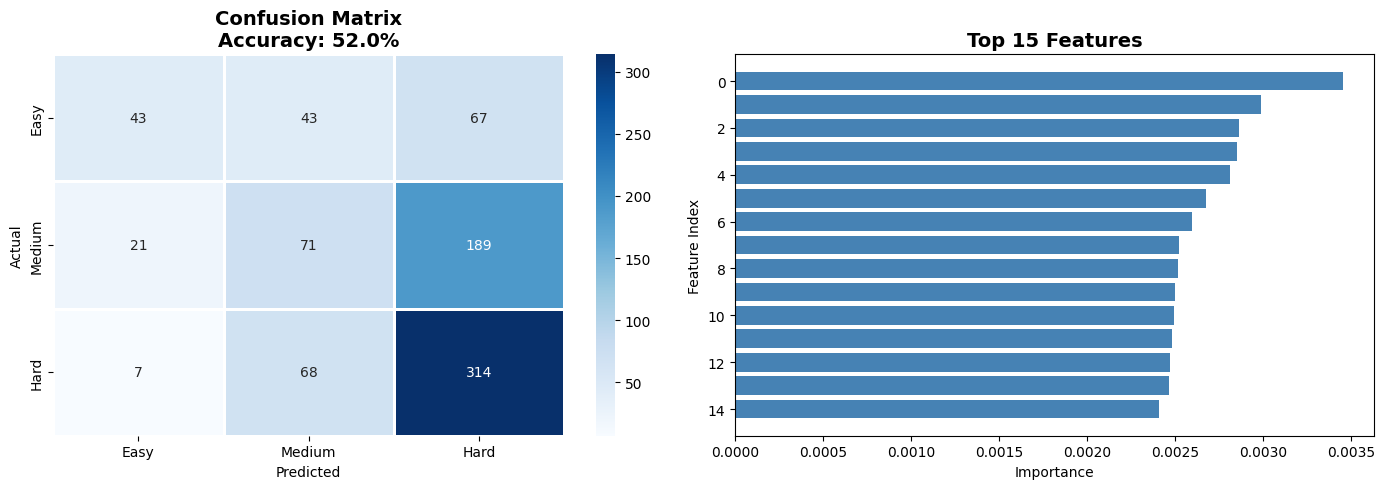


✓ Visualization saved as 'results.png'


In [19]:
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

# Predictions
yc_pred = clf.predict(X_test)
ys_pred = reg.predict(X_test)

# Score-based classification
yc_score = np.where(ys_pred < 3, 0, np.where(ys_pred < 7, 1, 2))

# Ensemble
yc_ensemble = np.round((yc_pred + yc_score) / 2).astype(int)

# Calculate metrics
acc_clf = accuracy_score(yc_test, yc_pred)
acc_score = accuracy_score(yc_test, yc_score)
acc_ensemble = accuracy_score(yc_test, yc_ensemble)
mae = mean_absolute_error(ys_test, ys_pred)
r2 = r2_score(ys_test, ys_pred)

# Print results
print(f"\n🎯 Classification Accuracy:")
print(f"   Direct XGBoost:  {acc_clf:.2%}")
print(f"   Score-based:     {acc_score:.2%}")
print(f"   Ensemble (BEST): {acc_ensemble:.2%} ⭐")

print(f"\n📊 Score Prediction:")
print(f"   MAE: {mae:.3f}")
print(f"   R²:  {r2:.3f}")

print(f"\n📋 Per-Class Performance (Ensemble):")
print(classification_report(yc_test, yc_ensemble,
                          target_names=['Easy', 'Medium', 'Hard'],
                          digits=3))

# Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classification confusion matrix
cm = confusion_matrix(yc_test, yc_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Easy', 'Medium', 'Hard'],
            yticklabels=['Easy', 'Medium', 'Hard'],
            ax=axes[0], linewidths=1)
axes[0].set_title(f'Confusion Matrix\nAccuracy: {acc_ensemble:.1%}',
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Feature importance
importances = clf.feature_importances_
top_idx = np.argsort(importances)[-15:][::-1]
axes[1].barh(range(15), importances[top_idx], color='steelblue')
axes[1].set_ylabel('Feature Index')
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Features', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'results.png'")

#

In [20]:
print("\n" + "="*60)
print("SAVING MODELS")
print("="*60)

# Package everything
models = {
    'clf': clf,
    'reg': reg,
    'scaler': scaler,
    'tfidf': tfidf,
    'extractor': extractor,
    'metrics': {
        'accuracy': acc_ensemble,
        'accuracy_clf': acc_clf,
        'accuracy_score': acc_score,
        'mae': mae,
        'r2': r2
    },
    'config': {
        'embeddings': USE_EMBEDDINGS,
        'auto_tune': AUTO_TUNE,
        'n_features': X.shape[1]
    }
}

# Save to CURRENT DIRECTORY (not /home/claude/)
filename = 'optimized_model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(models, f)

file_size = os.path.getsize(filename) / 1024 / 1024
print(f"✓ Model saved: {filename}")
print(f"✓ File size: {file_size:.1f} MB")

# Auto-download in Colab
print("\n📥 Downloading model file...")
try:
    from google.colab import files
    files.download(filename)
    files.download('results.png')
    print("✓ Download started!")
except ImportError:
    print("(Not in Colab - files saved locally)")

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"🎯 Final Accuracy: {acc_ensemble:.2%}")
print(f"📊 Score MAE: {mae:.3f}")
print(f"⚡ Features: {X.shape[1]}")
print(f"💾 Model: {filename} ({file_size:.1f} MB)")
print(f"📈 Plot: results.png")

if not USE_EMBEDDINGS:
    print("\n💡 Tip: Set USE_EMBEDDINGS=True for +2-3% accuracy")
if not AUTO_TUNE:
    print("💡 Tip: Set AUTO_TUNE=True for +2-3% accuracy")

print("="*60)

#


SAVING MODELS
✓ Model saved: optimized_model.pkl
✓ File size: 1.3 MB

📥 Downloading model file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download started!

✅ TRAINING COMPLETE!
🎯 Final Accuracy: 52.00%
📊 Score MAE: 1.641
⚡ Features: 1215
💾 Model: optimized_model.pkl (1.3 MB)
📈 Plot: results.png

💡 Tip: Set USE_EMBEDDINGS=True for +2-3% accuracy
💡 Tip: Set AUTO_TUNE=True for +2-3% accuracy


In [21]:
def predict_difficulty(title, description, input_desc=""):
    """Predict difficulty for a new problem"""

    # Combine text
    text = f"{title} {description} {input_desc}"

    # Extract features
    custom_feat = extractor.extract(text).reshape(1, -1)
    tfidf_feat = tfidf.transform([text]).toarray()

    if USE_EMBEDDINGS:
        emb = sbert.encode([text])
        features = np.hstack([custom_feat, tfidf_feat, emb])
    else:
        features = np.hstack([custom_feat, tfidf_feat])

    # Scale
    features = scaler.transform(features)

    # Predict
    class_pred = clf.predict(features)[0]
    score_pred = reg.predict(features)[0]
    confidence = clf.predict_proba(features).max()

    classes = ['Easy', 'Medium', 'Hard']
    return {
        'class': classes[class_pred],
        'score': round(float(score_pred), 1),
        'confidence': round(float(confidence), 3)
    }

# Test prediction
print("\n🧪 Testing prediction function...")
test_result = predict_difficulty(
    title="Two Sum Problem",
    description="Given an array of integers and a target, find two numbers that add up to the target.",
    input_desc="First line: n, Second line: n integers, Third line: target"
)

print(f"Test prediction: {test_result}")
print("\n✓ Model ready for deployment!")
print("\n📌 To use:")
print("   result = predict_difficulty('Title', 'Description', 'Input format')")
print("   print(result)")


🧪 Testing prediction function...
Test prediction: {'class': 'Easy', 'score': 2.7, 'confidence': 0.6}

✓ Model ready for deployment!

📌 To use:
   result = predict_difficulty('Title', 'Description', 'Input format')
   print(result)
